**04_Modelling and training**

<u>Importing required modules</u>

In [14]:
#Data preprocessing
import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

#Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier

#Hyperparamter optimization
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

#Training
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score

#Handing warnings
import warnings
warnings.filterwarnings("ignore")
import pickle
import os

<u>Loading data</u>

- Extracting features and labels

In [2]:
for filename in os.listdir():
    if filename[-3:]=="pkl" or filename[:9]=="processed_train":
        X_train = pickle.load(open("X_train.pkl","rb"))
        X_test = pickle.load(open("X_test.pkl","rb"))
        y_train = pd.read_csv("processed_train",keep_default_na=False).sentiment
        y_test = pd.read_csv("processed_test",keep_default_na=False).sentiment
        print("FEATURES AND TARGETS LOADED SUCCESSFULLY")
        break
        
else:
    print("No such file")

FEATURES AND TARGETS LOADED SUCCESSFULLY


In [3]:
#Features
X_train[0].shape,X_test[0].shape

((50,), (50,))

In [4]:
# X_train = np.abs(X_train[0])
# X_test = np.abs(X_test[0])

In [5]:
X_train.shape,X_test.shape

((27480, 50), (3534, 50))

In [6]:
#Targets
y_train.shape,y_test.shape

((27480,), (3534,))

- Model Selection

In [7]:
# #KNN model
knn = KNeighborsClassifier()
knn_param_grid = {"n_neighbors":range(3,25,2),
                 "weights":["uniform","distance"],
                 "metric":["manhattan","euclidean","minkowski"]}
rs_knn = RandomizedSearchCV(knn,param_distributions=knn_param_grid,n_iter=30,cv=5)
rs_knn.fit(X_train,y_train)
rs_knn.best_params_

{'weights': 'uniform', 'n_neighbors': 23, 'metric': 'minkowski'}

In [8]:
knn_model = rs_knn.best_estimator_
pickle.dump(knn_model,open("KNN_Model.pkl","wb"))

In [9]:
#SVC model
svc = SVC().fit(X_train,y_train)

In [10]:
pickle.dump(svc,open("SVC_Model.pkl","wb"))

*Won't be performing hyperparamter optimization for SVM because it takes too much time*

In [11]:
#Naive bayes
mnb = MultinomialNB()
gnb = GaussianNB()
bnb = BernoulliNB()
#These models are fast so we do not need to save the trained model

In [12]:
#Logistic Regression Classifier
lr = LogisticRegression()
lr_param_grid = {'C':[0.1,1,10,100],
                 'penalty':['l1','l2'],
                 'solver':['liblinear','saga','lbfgs']}
# lr_rs = RandomizedSearchCV(lr,param_distributions=lr_param_grid,n_iter=15,cv=5)
lr_gs = GridSearchCV(lr,param_grid=lr_param_grid,cv=5)
lr_gs.fit(X_train,y_train)
lr_gs.best_params_

{'C': 100, 'penalty': 'l1', 'solver': 'saga'}

In [13]:
lr_model = lr_gs.best_estimator_
pickle.dump(lr_model,open("LineaerRegression_Model.pkl","wb"))

In [14]:
#RandomForest
rf = RandomForestClassifier()
rf_param_grid = {"n_estimators":np.arange(10,1000,100),
                  "max_depth":[None,3,5,10],
                  "min_samples_split":np.arange(2,20,2),
                  "min_samples_leaf":np.arange(1,20,2),
                  "max_features":range(2,10,2),
                  "max_samples":[10000]}
rf_rs = RandomizedSearchCV(rf,param_distributions=rf_param_grid,n_iter=20,cv=5)
# rf_gs = GridSearchCV(rf,param_grid=rf_param_grid,cv=5)
rf_rs.fit(X_train,y_train)
rf_rs.best_params_

{'n_estimators': 10,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_samples': 10000,
 'max_features': 8,
 'max_depth': None}

In [15]:
rf_model = rf_rs.best_estimator_
pickle.dump(rf_model,open("RandomForest_Model.pkl","wb"))

In [16]:
#Gradient Boosting Classifier
gb = GradientBoostingClassifier()
gb_param_grid = {"n_estimators":np.arange(10,100,10),
                  "learning_rate":[0.1,0.05,0.2],
                  "min_samples_leaf":np.arange(1,20,2),
                  "max_depth":[1,3,None],
                  "max_features":range(2,10,2)}
gb_rs = RandomizedSearchCV(gb,param_distributions=gb_param_grid,n_iter=20,cv=5)
# gb_rs = GridSearchCV(gb,param_grid=gb_param_grid,cv=5)
gb_rs.fit(X_train,y_train)
gb_rs.best_params_

{'n_estimators': 40,
 'min_samples_leaf': 7,
 'max_features': 4,
 'max_depth': None,
 'learning_rate': 0.1}

In [17]:
gb_model = gb_rs.best_estimator_
pickle.dump(gb_model,open("GradientBoosting_Model.pkl","wb"))

Voting Classifier

In [18]:
#Won't give SVM as an estimator because it takes too much time here too, will compare it's performance with voting classifier later
estimator = []
classifiers = ["MultinomialNB","GaussianNB","BernoulliNB",
               "KNN","LogisticRegression",
               "RandomForest","GradientBoosting","SVM"]
models = [mnb,gnb,bnb,
          pickle.load(open("KNN_Model.pkl","rb")),
          pickle.load(open("LineaerRegression_Model.pkl","rb")),
          pickle.load(open("RandomForest_Model.pkl","rb")),
          pickle.load(open("GradientBoosting_Model.pkl","rb")),
          pickle.load(open("SVC_Model.pkl","rb"))] 
for i,j in zip(classifiers,models):
    estimator.append((i,j))
estimator

[('MultinomialNB', MultinomialNB()),
 ('GaussianNB', GaussianNB()),
 ('BernoulliNB', BernoulliNB()),
 ('KNN', KNeighborsClassifier(n_neighbors=23)),
 ('LogisticRegression',
  LogisticRegression(C=100, penalty='l1', solver='saga')),
 ('RandomForest',
  RandomForestClassifier(max_features=8, max_samples=10000, min_samples_leaf=3,
                         n_estimators=10)),
 ('GradientBoosting',
  GradientBoostingClassifier(max_depth=None, max_features=4, min_samples_leaf=7,
                             n_estimators=40)),
 ('SVM', SVC())]

In [19]:
#Voting Classifier
vc = VotingClassifier(estimators=estimator)

<u>Training model</u>

In [20]:
vc.fit(X_train,y_train)

VotingClassifier(estimators=[('MultinomialNB', MultinomialNB()),
                             ('GaussianNB', GaussianNB()),
                             ('BernoulliNB', BernoulliNB()),
                             ('KNN', KNeighborsClassifier(n_neighbors=23)),
                             ('LogisticRegression',
                              LogisticRegression(C=100, penalty='l1',
                                                 solver='saga')),
                             ('RandomForest',
                              RandomForestClassifier(max_features=8,
                                                     max_samples=10000,
                                                     min_samples_leaf=3,
                                                     n_estimators=10)),
                             ('GradientBoosting',
                              GradientBoostingClassifier(max_depth=None,
                                                         max_features=4,
                       

In [21]:
#Creating a pickle file of votingClassifier model
pickle.dump(vc,open("voting_Model.pkl","wb"))

In [22]:
#Time taken by each estimator in voting classifier
for name, clf in tqdm(vc.named_estimators.items()):
    print(name)
    clf.fit(X_train, y_train)

 38%|███████████████████████████████▌                                                    | 3/8 [00:00<00:00, 24.43it/s]

MultinomialNB
GaussianNB
BernoulliNB
KNN
LogisticRegression


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:03<00:01,  1.37it/s]

RandomForest
GradientBoosting
SVM


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:54<00:00,  6.79s/it]


In [7]:
vc = pickle.load(open("voting_Model.pkl","rb"))

In [8]:
vc.score(X_train,y_train),vc.score(X_test,y_test)

(0.6709243085880641, 0.6001697792869269)

Evaluation 

In [11]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

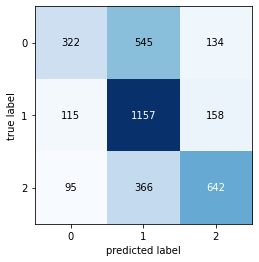

In [15]:
matrix = confusion_matrix(y_test,vc.predict(X_test))
fig, ax = plot_confusion_matrix(conf_mat=matrix)
plt.show()